In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
average_age = train_data['Age'].mean()
std_age = train_data['Age'].std()
count_age = train_data['Age'].isnull().sum()

random_1 = np.random.randint(average_age - std_age, average_age + std_age,size = count_age)

train_data['Age'][np.isnan(train_data['Age'])]=random_1

In [4]:
train_data['Age'] = train_data['Age'].round().astype(int)

In [5]:
average_age = test_data['Age'].mean()
std_age = test_data['Age'].std()
count_age = test_data['Age'].isnull().sum()

In [6]:
random_1 = np.random.randint(average_age - std_age, average_age + std_age,size = count_age)
test_data['Age'][np.isnan(test_data['Age'])] = random_1
test_data['Age'] = test_data['Age'].astype(int)

In [7]:
train_data['AgeBucket'] = train_data['Age']//15 * 15
test_data['AgeBucket'] = test_data['Age']//15 * 15

In [8]:
train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']
test_data['RelativesOnboard'] = test_data['SibSp'] + test_data['Parch']

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64, handle_unknown='error'):

        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
            "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
            "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
            " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):

        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:

                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Fare",'RelativesOnboard'])),
        ("imputer", SimpleImputer(strategy="median")),
        ('Scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked","AgeBucket"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

In [14]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [15]:
X_train = preprocess_pipeline.fit_transform(train_data)
y_train = train_data['Survived']

In [16]:
X_train

array([[-0.50244517,  0.05915988,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78684529,  0.05915988,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.48885426, -0.56097483,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.17626324,  1.29942929,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04438104, -0.56097483,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.49237783, -0.56097483,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

validation_size = 0.2
seed = 7
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=seed)

X_val.shape

(179, 16)

In [19]:
X_DataFrame = pd.DataFrame(X_train)

In [20]:
train_cat = train_data[["Pclass", "Sex", "Embarked","AgeBucket"]]

In [21]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
imputer = MostFrequentImputer()

In [22]:
train_filled = imputer.fit_transform(train_cat)

In [23]:
cat_encoder.fit_transform(train_filled)

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
cat_encoder.categories_

[array([1, 2, 3], dtype=object),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object),
 array([0, 15, 30, 45, 60, 75], dtype=object)]

In [25]:
train_cat

,Pclass,Sex,Embarked,AgeBucket
0,3,male,S,15
1,1,female,C,30
2,3,female,S,15
3,1,female,S,30
4,3,male,S,30
...,...,...,...,...
886,2,male,S,15
887,1,female,S,15
888,3,female,S,30
889,1,male,C,15


In [26]:
X_columns = ["Fare",'RelativesOnboard',1, 2, 3,'female', 'male','C', 'Q', 'S',0, 15, 30, 45, 60, 75]

In [27]:
X_DataFrame.columns = X_columns

In [28]:
X_DataFrame.head()

,Fare,RelativesOnboard,1,2,3,female,male,C,Q,S,0,15,30,45,60,75
0,-0.437762,0.059160,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.336334,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.025945,0.679295,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.491874,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.502949,-0.560975,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
X_test = test_data
gender_submission = pd.read_csv("gender_submission.csv")
y_real = gender_submission["Survived"]

In [30]:
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []

In [31]:
from sklearn.linear_model import LogisticRegression
models.append(('LR', LogisticRegression()))

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
models.append(('LDA', LinearDiscriminantAnalysis()))

In [33]:
from sklearn.neighbors import KNeighborsClassifier
models.append(('KNN', KNeighborsClassifier()))

In [34]:
from sklearn.tree import DecisionTreeClassifier
models.append(('CART', DecisionTreeClassifier()))

In [35]:
from sklearn.naive_bayes import GaussianNB
models.append(('NB', GaussianNB()))

In [36]:
from sklearn.svm import SVC
models.append(('SVM', SVC()))

In [37]:
result = []
names = []

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [38]:
for name, model in models :

    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    result.append(cv_results)
    names.append(name)
    msg = "%s%f%f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR0.8062600.055779
LDA0.8175270.052422
KNN0.7950700.070570
CART0.7923120.069787
NB0.8020930.051495
SVM0.8456380.051667


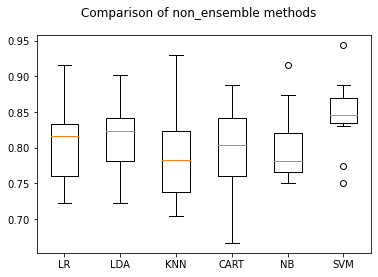

In [39]:
fig = plt.figure()
fig.suptitle('Comparison of non_ensemble methods')
ax = fig.add_subplot(111)
plt.boxplot(result)
ax.set_xticklabels(names)
plt.show()

In [40]:
c_values = [1, 5, 10, 50, 100]
gammas = [1, 10, 100, 1000]
kernel_values=['rbf']

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid=dict(C=c_values, kernel=kernel_values, gamma = gammas)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [42]:
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.818975 using {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [43]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [44]:
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

0.818975 (0.057539) with: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.741725 (0.071507) with: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.715063 (0.075293) with: {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
0.702406 (0.074267) with: {'C': 1, 'gamma': 1000, 'kernel': 'rbf'}
0.796577 (0.077231) with: {'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.738869 (0.068046) with: {'C': 5, 'gamma': 10, 'kernel': 'rbf'}
0.719268 (0.071871) with: {'C': 5, 'gamma': 100, 'kernel': 'rbf'}
0.700998 (0.079177) with: {'C': 5, 'gamma': 1000, 'kernel': 'rbf'}
0.799394 (0.070773) with: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.734644 (0.066402) with: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.722066 (0.071010) with: {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
0.700998 (0.079177) with: {'C': 10, 'gamma': 1000, 'kernel': 'rbf'}
0.797985 (0.078225) with: {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
0.740317 (0.077826) with: {'C': 50, 'gamma': 10, 'kernel': 'rbf'}
0.717879 (0.079373) with: {'C': 50, 'gamma': 100, 'kernel': 'rbf'}
0.698220 (0.

In [45]:
c_values = [x/10 for x in range(5,15)]
gammas = [x/10 for x in range(5,15)]
kernel_values=['rbf']

from sklearn.model_selection import GridSearchCV

param_grid=dict(C=c_values, kernel=kernel_values, gamma = gammas)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.841412 using {'C': 0.6, 'gamma': 0.5, 'kernel': 'rbf'}


In [46]:
param_grid=dict(C=c_values, kernel=kernel_values, gamma = gammas)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.841412 using {'C': 0.6, 'gamma': 0.5, 'kernel': 'rbf'}
0.840023 (0.052882) with: {'C': 0.5, 'gamma': 0.5, 'kernel': 'rbf'}
0.835798 (0.053247) with: {'C': 0.5, 'gamma': 0.6, 'kernel': 'rbf'}
0.828815 (0.054480) with: {'C': 0.5, 'gamma': 0.7, 'kernel': 'rbf'}
0.827406 (0.054223) with: {'C': 0.5, 'gamma': 0.8, 'kernel': 'rbf'}
0.823181 (0.055053) with: {'C': 0.5, 'gamma': 0.9, 'kernel': 'rbf'}
0.823200 (0.054600) with: {'C': 0.5, 'gamma': 1.0, 'kernel': 'rbf'}
0.821772 (0.053203) with: {'C': 0.5, 'gamma': 1.1, 'kernel': 'rbf'}
0.821772 (0.053923) with: {'C': 0.5, 'gamma': 1.2, 'kernel': 'rbf'}
0.816197 (0.059402) with: {'C': 0.5, 'gamma': 1.3, 'kernel': 'rbf'}
0.811991 (0.059576) with: {'C': 0.5, 'gamma': 1.4, 'kernel': 'rbf'}
0.841412 (0.052871) with: {'C': 0.6, 'gamma': 0.5, 'kernel': 'rbf'}
0.835818 (0.053550) with: {'C': 0.6, 'gamma': 0.6, 'kernel': 'rbf'}
0.830223 (0.054335) with: {'C': 0.6, 'gamma': 0.7, 'kernel': 'rbf'}
0.824589 (0.055414) with: {'C': 0.6, 'gamma': 0.8, 'k

In [47]:
c_values = [x/10 for x in range(10,20)]
gammas = [x/10 for x in range(1,10)]
kernel_values=['rbf']

from sklearn.model_selection import GridSearchCV

param_grid=dict(C=c_values, kernel=kernel_values, gamma = gammas)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.847046 using {'C': 1.1, 'gamma': 0.2, 'kernel': 'rbf'}


In [48]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

0.840023 (0.055734) with: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.845638 (0.051667) with: {'C': 1.0, 'gamma': 0.2, 'kernel': 'rbf'}
0.844229 (0.052236) with: {'C': 1.0, 'gamma': 0.3, 'kernel': 'rbf'}
0.838654 (0.055693) with: {'C': 1.0, 'gamma': 0.4, 'kernel': 'rbf'}
0.834448 (0.055852) with: {'C': 1.0, 'gamma': 0.5, 'kernel': 'rbf'}
0.830203 (0.054450) with: {'C': 1.0, 'gamma': 0.6, 'kernel': 'rbf'}
0.830203 (0.053315) with: {'C': 1.0, 'gamma': 0.7, 'kernel': 'rbf'}
0.827406 (0.053855) with: {'C': 1.0, 'gamma': 0.8, 'kernel': 'rbf'}
0.821792 (0.055968) with: {'C': 1.0, 'gamma': 0.9, 'kernel': 'rbf'}
0.841432 (0.054948) with: {'C': 1.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.847046 (0.051824) with: {'C': 1.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.845638 (0.052429) with: {'C': 1.1, 'gamma': 0.3, 'kernel': 'rbf'}
0.838654 (0.055693) with: {'C': 1.1, 'gamma': 0.4, 'kernel': 'rbf'}
0.834448 (0.055852) with: {'C': 1.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.828815 (0.056271) with: {'C': 1.1, 'gamma': 0.

In [49]:
svm_clf = SVC(C=1.1, kernel='rbf', gamma=0.2)
svm_clf.fit(X_train,y_train)

SVC(C=1.1, gamma=0.2)

In [50]:
y_pred = svm_clf.predict(X_val)

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
svc_mse = mean_squared_error(y_val, y_pred)
svc_rmse = np.sqrt(svc_mse)

In [53]:
svc_rmse

0.46677306581685607

In [54]:
neighbors = [1,3,5,7,9,15,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train,y_train)

print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.814789 using {'n_neighbors': 21}


In [55]:
knn_clf = KNeighborsClassifier(n_neighbors= 21)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_val)

In [56]:
knn_mse = mean_squared_error(y_val, y_pred)
knn_rmse = np.sqrt(knn_mse)

In [57]:
knn_rmse

0.46677306581685607